# Smoothing Splines

This notebook shows several examples of smoothing splines.

## Deep dive into smoothing splines

Make sure to read https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html from Scipy docs that explains smoothing splines in detail.

## BSpline

In [1]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

All cell outputs in this notebook are stripped from source code. To see the outputs, run the notebook locally or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dr-QP/Dr.QP/blob/main/notebooks/3_1_appendix_smoothing_splines.ipynb)

### Note for non default branch

If you are viewing non default branch change `--branch=main` below to branch name you are viewing.

## Runtime restart!!

The runtime need to be restarted to pick up the new modules. The code below will install them and kill runtime, simply run all cells again afterwards

In [2]:
# Setup for Google Colab
import importlib.util

IN_COLAB = (
    importlib.util.find_spec('google') is not None
    and importlib.util.find_spec('google.colab') is not None
)

if IN_COLAB:
    try:
        import plotting  # noqa: F401
        import point  # noqa: F401
    except ImportError:
        !git clone --filter=blob:none --no-checkout --depth 1 --sparse https://github.com/Dr-QP/Dr.QP.git --branch=main
        !cd Dr.QP && git sparse-checkout add notebooks && git checkout && cd ..
        !mv Dr.QP/notebooks/* .
        !mv Dr.QP/* .
        !rm -rf Dr.QP
        %pip install -r requirements.txt
        print('\n\n\nRestarting runtime to pick up the new modules...')
        import os

        os.kill(os.getpid(), 9)

In [3]:
%matplotlib ipympl

import matplotlib.pyplot as plt

plt.ioff() # this is equivalent to using inline backend, but figures have to be displayed manually

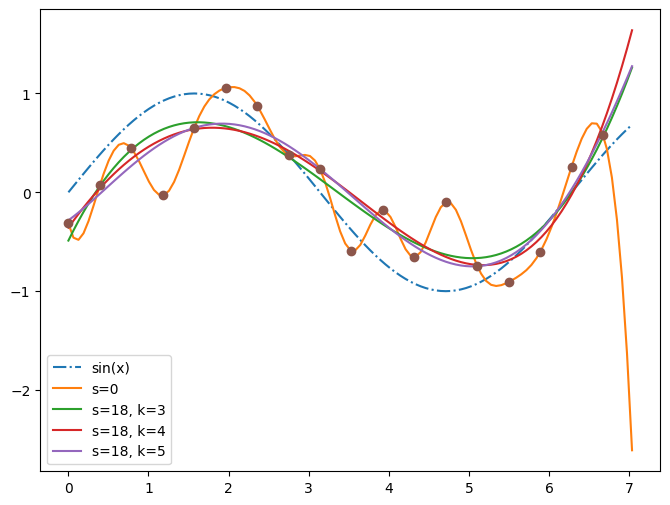

In [4]:
# Example from https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_splrep

x = np.arange(0, 2 * np.pi + np.pi / 4, 2 * np.pi / 16)
rng = np.random.default_rng()
y = np.sin(x) + 0.4 * rng.standard_normal(size=len(x))


xnew = np.arange(0, 9 / 4, 1 / 50) * np.pi

fig = plt.figure(figsize=(8, 6))
plt.plot(xnew, np.sin(xnew), '-.', label='sin(x)')
plt.plot(xnew, make_splrep(x, y, s=0, k=4)(xnew), '-', label='s=0')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=3)(xnew), '-', label=f's={len(x)}, k=3')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=4)(xnew), '-', label=f's={len(x)}, k=4')
plt.plot(xnew, make_splrep(x, y, s=len(x), k=5)(xnew), '-', label=f's={len(x)}, k=5')
plt.plot(x, y, 'o')
plt.legend()

display(fig)

## BSpline in application to gaits trajectory approximation

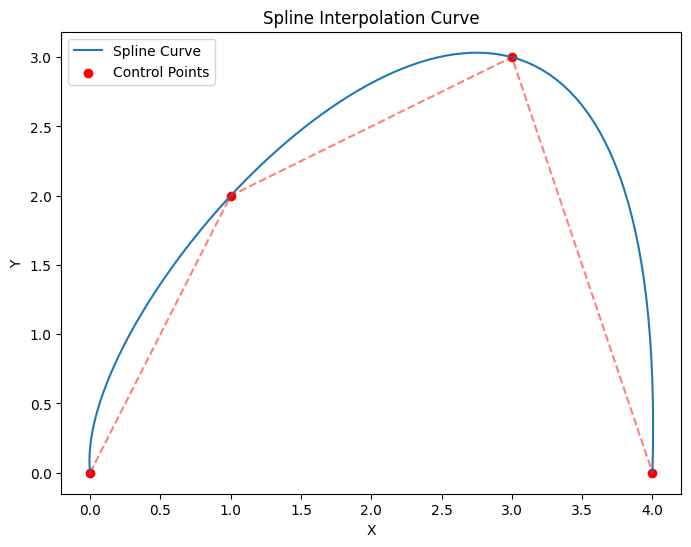

In [5]:
from scipy.interpolate import make_interp_spline


def bezier_spline(control_points, num_points=100):
    """
    Compute a smooth spline interpolation of control points using make_interp_spline.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param num_points: Number of points in the interpolated curve
    :return: Interpolated curve points
    """
    control_x, control_y = zip(*control_points)
    t = np.linspace(0, 1, len(control_points))

    spline_x = make_interp_spline(t, control_x, k=3)
    spline_y = make_interp_spline(t, control_y, k=3)

    return spline_x, spline_y


control_points = np.array([[0, 0], [1, 2], [3, 3], [4, 0]])

spline_x, spline_y = bezier_spline(control_points)


# Plot curve and control points
control_x, control_y = zip(*control_points)

# Evaluate the spline at a sequence of points
t = np.linspace(0, 1, 100)
curve_x = spline_x(t)
curve_y = spline_y(t)

fig = plt.figure(figsize=(8, 6))
plt.plot(curve_x, curve_y, label='Spline Curve')
plt.scatter(control_x, control_y, color='red', label='Control Points')
plt.plot(control_x, control_y, 'r--', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spline Interpolation Curve')
display(fig)

## Bezier curve using B-spline

The SciPy's BSpline class can represent Bezier curves, as Bezier curves are a special case of B-splines.

To define a Bezier curve in SciPy, one needs to specify the control points and the degree of the curve. For example, a cubic Bezier curve (degree 3) requires four control points. The BSpline class then creates a spline object, which can be evaluated at any point to obtain the corresponding point on the curve.

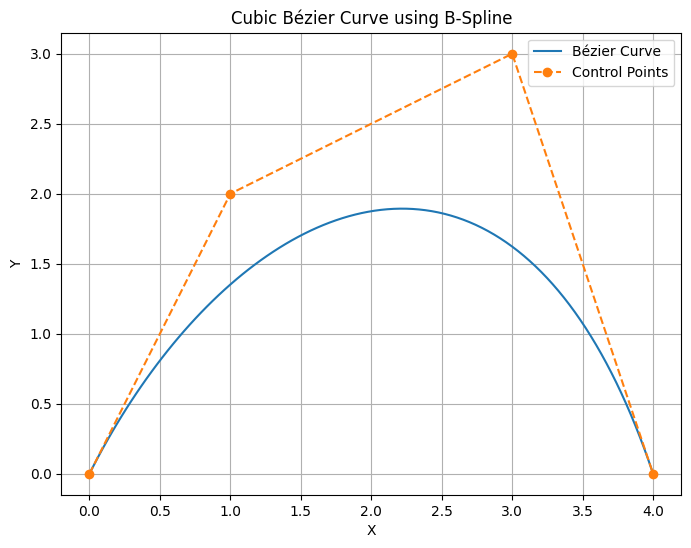

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import BSpline

# Define control points for a cubic Bezier curve
control_points = np.array([[0, 0], [1, 2], [3, 3], [4, 0]])

# Define the degree of the curve (cubic)
degree = 3

# Create a clamped knot vector for a cubic Bézier curve with 4 control points
knots = [0, 0, 0, 0, 1, 1, 1, 1]

# Create the BSpline object (each coordinate must be passed separately)
spl_x = BSpline(knots, control_points[:, 0], degree)
spl_y = BSpline(knots, control_points[:, 1], degree)

# Evaluate the spline at a sequence of points
t = np.linspace(0, 1, 100)
curve_points_x = spl_x(t)
curve_points_y = spl_y(t)

# Plot the curve and control points
fig = plt.figure(figsize=(8, 6))
plt.plot(curve_points_x, curve_points_y, label='Bézier Curve')
plt.plot(control_points[:, 0], control_points[:, 1], 'o--', label='Control Points')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Cubic Bézier Curve using B-Spline')
plt.grid()
display(fig)

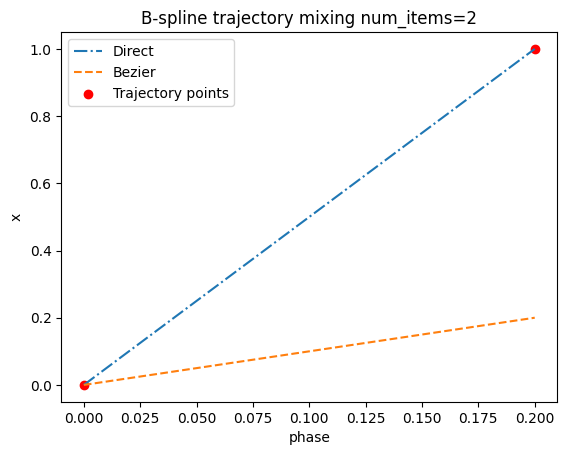

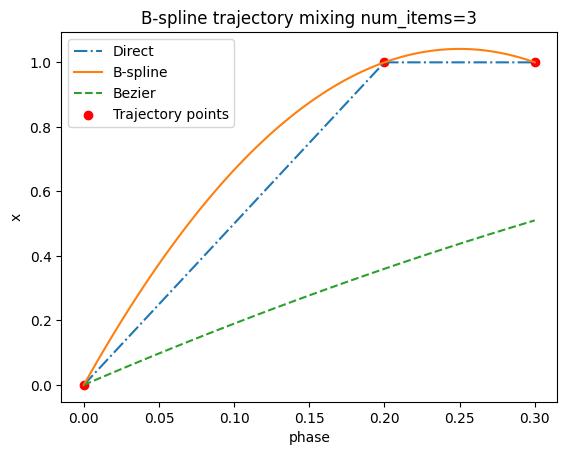

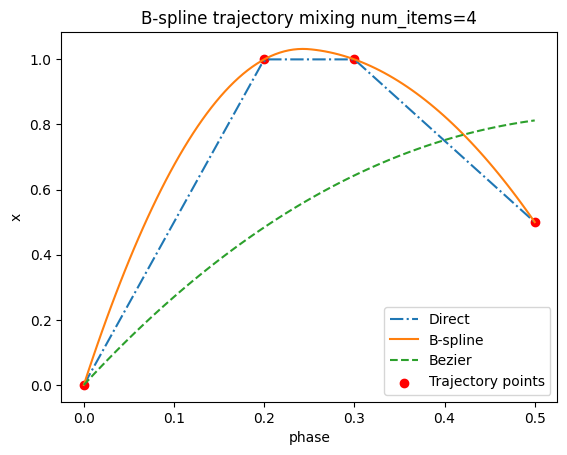

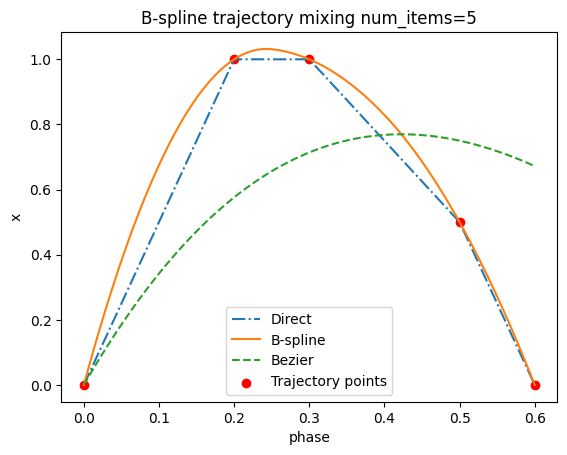

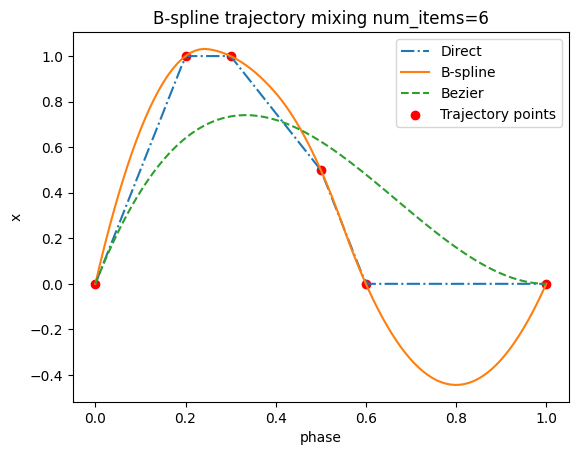

In [7]:
from math import comb

import matplotlib.pyplot as plt


def bezier_curve(control_points: np.ndarray, t):
    """
    Compute a point on a Bézier curve using the Bernstein polynomial form.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param t: Parameter in range [0,1]
    :return: (x, y) coordinate of the curve at parameter t
    """
    control_points = np.array(control_points)
    n = len(control_points) - 1
    result = np.zeros(control_points.shape[1])

    for i, p in enumerate(control_points):
        bernstein = comb(n, i) * (t**i) * ((1 - t) ** (n - i))
        result += bernstein * p

    return result


spline_x_all = np.array([0, 0.2, 0.3, 0.5, 0.6, 1.0])
spline_z_all = np.array(
    [
        0,
        1,
        1,
        0.5,
        0,
        0,
    ]
)

for num_items in range(2, len(spline_x_all) + 1):
    fig, axes = plt.subplots(1, 1)
    spline_x = np.array([0, 0.2, 0.3, 0.5, 0.6, 1.0])[0:num_items]
    spline_z = np.array(
        [
            0,
            1,
            1,
            0.5,
            0,
            0,
        ]
    )[0:num_items]
    direct_trajectory = make_interp_spline(spline_x, spline_z, k=1) if num_items > 1 else None
    bspline_trajectory = make_interp_spline(spline_x, spline_z, k=2) if num_items > 2 else None

    phase = np.linspace(0, spline_x[-1], 100)

    ##############################
    ax = axes
    ax.set_xlabel('phase')
    ax.set_ylabel('x')
    ax.set_title(f'B-spline trajectory mixing {num_items=}')

    ax.plot(
        phase, direct_trajectory(phase), linestyle='-.', label='Direct'
    ) if direct_trajectory else None
    ax.plot(phase, bspline_trajectory(phase), label='B-spline') if bspline_trajectory else None
    ax.plot(
        phase,
        [bezier_curve(np.array([spline_x, spline_z]).T, t)[1] for t in phase],
        linestyle='--',
        label='Bezier',
    )
    ax.scatter(spline_x, spline_z, c='r', label='Trajectory points')
    ax.legend()
    display(fig)

## Pure python implementation of Bézier curve

Here's a pure Python function for a Bézier curve of any degree, parameterized by $t$ in the range $[0,1]$. It uses the Bernstein polynomial form to compute the interpolated point for a given $t$.

### Bezier Interpolation

This function computes a Bézier curve point for a given $t$ by iterating through control points and applying the Bernstein polynomial formula.

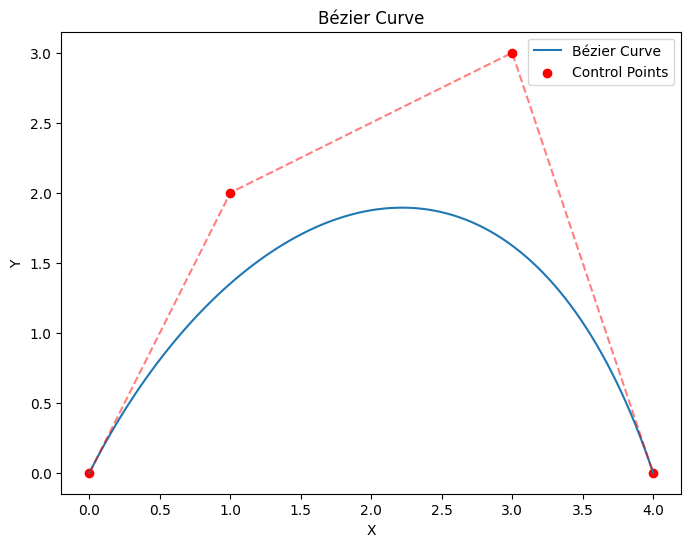

In [8]:
import matplotlib.pyplot as plt


def bezier_curve(control_points: np.ndarray, t):
    """
    Compute a point on a Bézier curve using the Bernstein polynomial form.

    :param control_points: List of control points [(x0, y0), (x1, y1), ...]
    :param t: Parameter in range [0,1]
    :return: (x, y) coordinate of the curve at parameter t
    """
    control_points = np.array(control_points)
    n = len(control_points) - 1
    result = np.zeros(control_points.shape[1])

    for i, p in enumerate(control_points):
        bernstein = comb(n, i) * (t**i) * ((1 - t) ** (n - i))
        result += bernstein * p

    return result


# Example usage
control_pts = [(0, 0), (1, 2), (3, 3), (4, 0)]
t_values = [i / 100 for i in range(101)]
points = [bezier_curve(control_pts, t) for t in t_values]

# Plot curve and control points
curve_x, curve_y = zip(*points)
control_x, control_y = zip(*control_pts)

fig = plt.figure(figsize=(8, 6))
plt.plot(curve_x, curve_y, label='Bézier Curve')
plt.scatter(control_x, control_y, color='red', label='Control Points')
plt.plot(control_x, control_y, 'r--', alpha=0.5)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Bézier Curve')
display(fig)

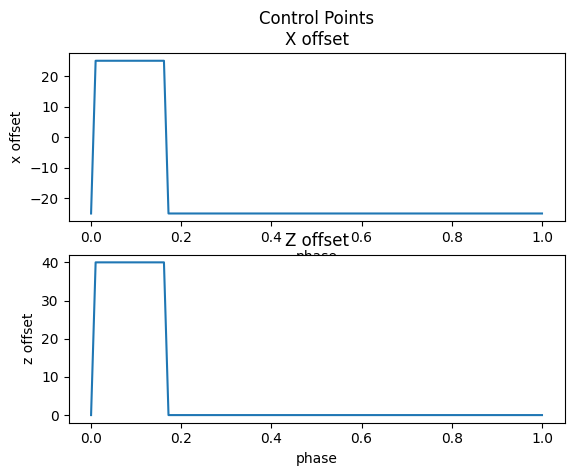

In [9]:
phase = np.linspace(0, 1, 100)


def leg_control_point(phase):
    lift_duration = 1 / 6
    step_height = 40
    half_step = 50 / 2

    if phase > 0.0001 and phase < lift_duration:
        # Swing phase - leg in air moving forward
        x_control_point = half_step
        z_control_point = step_height
    else:
        # Stance phase - leg on ground moving backward
        x_control_point = -half_step
        z_control_point = 0  # On ground

    return x_control_point, z_control_point


fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Control Points\nX offset')
ax[0].plot(phase, [leg_control_point(p)[0] for p in phase])

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, [leg_control_point(p)[1] for p in phase])

display(fig)

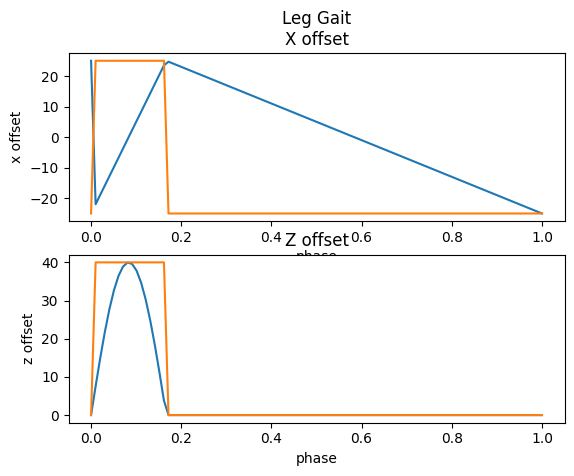

In [10]:
phase = np.linspace(0, 1, 100)


def leg_gait_point(phase):
    lift_duration = 1 / 6
    step_height = 40
    half_step = 50 / 2

    if phase > 0.0001 and phase < lift_duration:
        # Swing phase - leg in air moving forward
        t = np.interp(phase, [0, lift_duration], [0, 1])
        x_control_point = np.interp(phase, [0, lift_duration], [-half_step, half_step])
        z_control_point = np.sin(t * np.pi) * step_height
    else:
        # Stance phase - leg on ground moving backward
        x_control_point = np.interp(phase, [lift_duration, 1], [half_step, -half_step])
        z_control_point = 0  # On ground

    return x_control_point, z_control_point


fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Leg Gait\nX offset')
ax[0].plot(phase, [leg_gait_point(p)[0] for p in phase])
ax[0].plot(phase, [leg_control_point(p)[0] for p in phase])

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, [leg_gait_point(p)[1] for p in phase])
ax[1].plot(phase, [leg_control_point(p)[1] for p in phase])

display(fig)

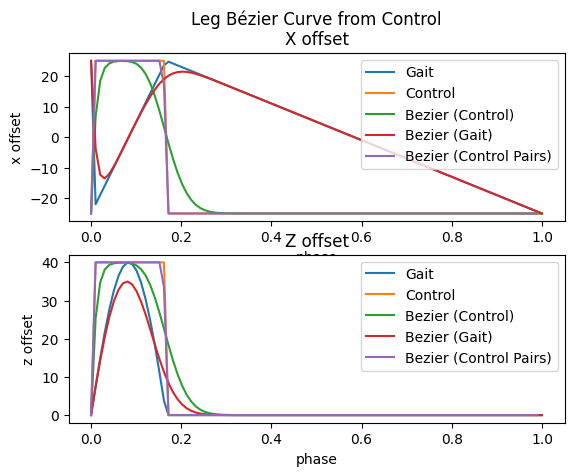

In [11]:
gait_points = np.array([leg_gait_point(p) for p in phase])
control_pts = np.array([leg_control_point(p) for p in phase])

bezier_control_pts = np.array([bezier_curve(control_pts, t) for t in phase])
bezier_gaits_points = np.array([bezier_curve(gait_points, t) for t in phase])

bezier_control_pts_pairs = []
for i in range(len(control_pts) - 1):
    p = bezier_curve(control_pts[i : i + 2], i / len(control_pts))
    bezier_control_pts_pairs.append(p)
bezier_control_pts_pairs = np.array(bezier_control_pts_pairs)

fig, ax = plt.subplots(2, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Leg Bézier Curve from Control\nX offset')
ax[0].plot(phase, gait_points[:, 0], label='Gait')
ax[0].plot(phase, control_pts[:, 0], label='Control')
ax[0].plot(phase, bezier_control_pts[:, 0], label='Bezier (Control)')
ax[0].plot(phase, bezier_gaits_points[:, 0], label='Bezier (Gait)')
ax[0].plot(phase[0:-1], bezier_control_pts_pairs[:, 0], label='Bezier (Control Pairs)')

ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, gait_points[:, 1], label='Gait')
ax[1].plot(phase, control_pts[:, 1], label='Control')
ax[1].plot(phase, bezier_control_pts[:, 1], label='Bezier (Control)')
ax[1].plot(phase, bezier_gaits_points[:, 1], label='Bezier (Gait)')
ax[1].plot(phase[0:-1], bezier_control_pts_pairs[:, 1], label='Bezier (Control Pairs)')

ax[1].legend()

display(fig)

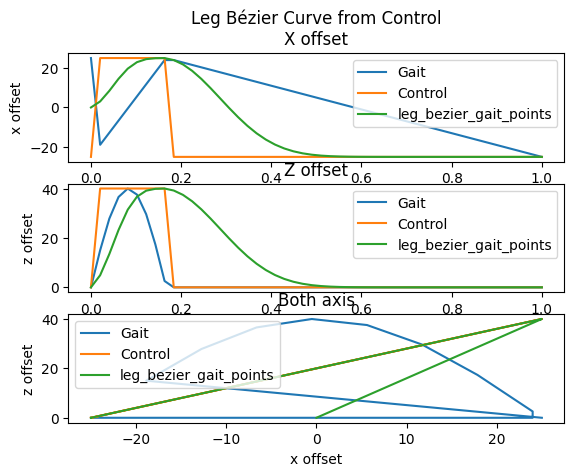

In [12]:
phase = np.linspace(0, 1, 50)


def leg_bezier_gait_point(last_pos, phase):
    lift_duration = 1 / 6
    step_height = 40
    half_step = 50 / 2

    if phase > 0.0001 and phase < lift_duration:
        # Swing phase - leg in air moving forward
        t = np.interp(phase, [0, lift_duration], [0, 1])
        x_control_point = half_step
        z_control_point = step_height
    else:
        # Stance phase - leg on ground moving backward
        t = np.interp(phase, [lift_duration, 1], [0, 1])
        x_control_point = -half_step
        z_control_point = 0  # On ground

    control_pos = np.array([x_control_point, z_control_point])
    return bezier_curve(np.array([last_pos, control_pos]), t)


gait_points = np.array([leg_gait_point(p) for p in phase])
control_pts = np.array([leg_control_point(p) for p in phase])

leg_bezier_gait_points = []
last_pos = np.array([0, 0])
for p in phase:
    last_pos = leg_bezier_gait_point(last_pos, p)
    leg_bezier_gait_points.append(last_pos)
leg_bezier_gait_points = np.array(leg_bezier_gait_points)

fig, ax = plt.subplots(3, 1)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('Leg Bézier Curve from Control\nX offset')
ax[0].plot(phase, gait_points[:, 0], label='Gait')
ax[0].plot(phase, control_pts[:, 0], label='Control')
ax[0].plot(phase, leg_bezier_gait_points[:, 0], label='leg_bezier_gait_points')

ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, gait_points[:, 1], label='Gait')
ax[1].plot(phase, control_pts[:, 1], label='Control')
ax[1].plot(phase, leg_bezier_gait_points[:, 1], label='leg_bezier_gait_points')

ax[1].legend()

# plot both axis
ax[2].set_xlabel('x offset')
ax[2].set_ylabel('z offset')
ax[2].set_title('Both axis')
ax[2].plot(gait_points[:, 0], gait_points[:, 1], label='Gait')
ax[2].plot(control_pts[:, 0], control_pts[:, 1], label='Control')
ax[2].plot(
    leg_bezier_gait_points[:, 0], leg_bezier_gait_points[:, 1], label='leg_bezier_gait_points'
)
ax[2].legend()

display(fig)

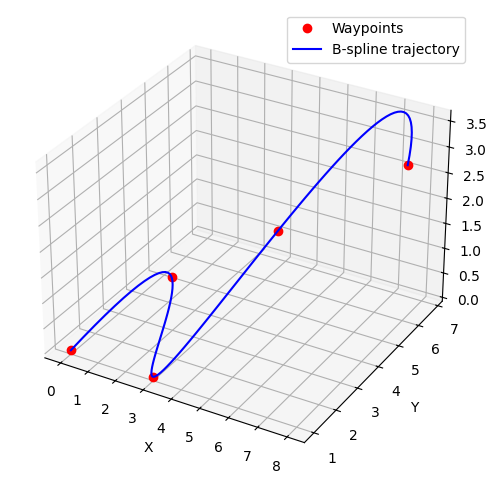

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Given non-uniformly spaced time points
t = np.array([0, 1, 2.5, 4, 6])  # Time values (not uniformly spaced)
x = np.array([0, 2, 3, 5, 8])  # X trajectory
y = np.array([1, 3, 1, 4, 6])  # Y trajectory
z = np.array([0, 1, 0, 2, 3])  # Z trajectory

# Define a finer time grid for smooth interpolation
t_fine = np.linspace(t[0], t[-1], 100)

# Create B-spline interpolators for each dimension
spline_x = make_interp_spline(t, x, k=3)  # Cubic B-spline
spline_y = make_interp_spline(t, y, k=3)
spline_z = make_interp_spline(t, z, k=3)

# Evaluate splines at the finer time grid
x_smooth = spline_x(t_fine)
y_smooth = spline_y(t_fine)
z_smooth = spline_z(t_fine)

# Plot the results
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, 'ro', label='Waypoints')  # Original points
ax.plot(x_smooth, y_smooth, z_smooth, 'b-', label='B-spline trajectory')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

display(fig)

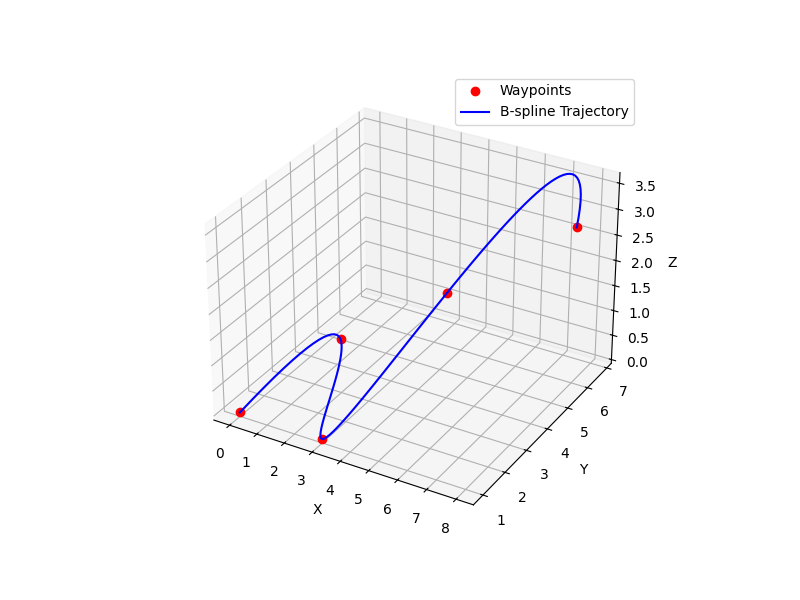

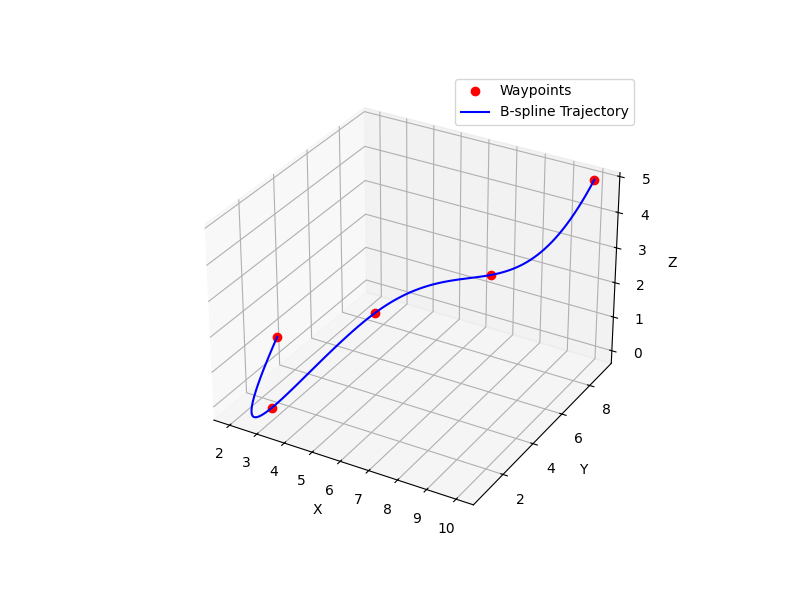

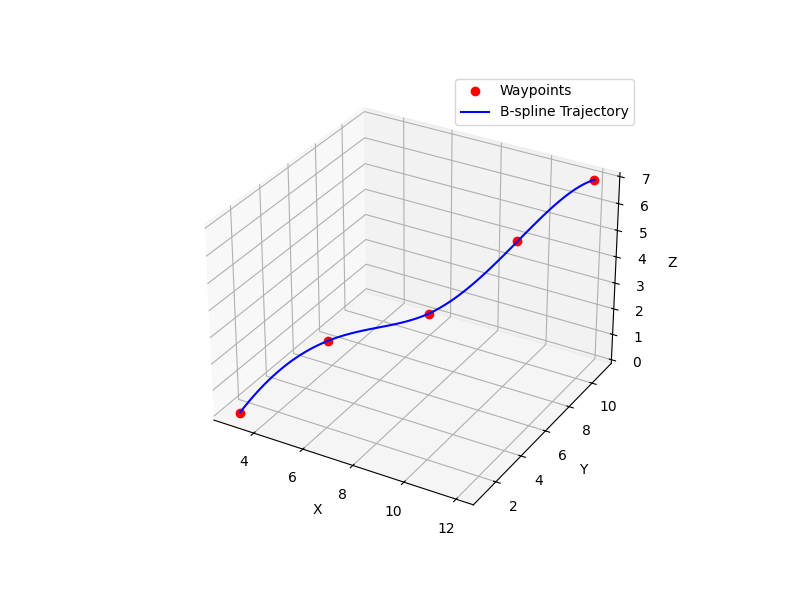

In [16]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Rolling buffer for waypoints (FIFO queue)
max_waypoints = 5  # Keep last N points
time_buffer = deque(maxlen=max_waypoints)
x_buffer = deque(maxlen=max_waypoints)
y_buffer = deque(maxlen=max_waypoints)
z_buffer = deque(maxlen=max_waypoints)

# Initialize with some waypoints
initial_waypoints = [(0, 0, 1, 0), (1, 2, 3, 1), (2.5, 3, 1, 0), (4, 5, 4, 2)]
for t, x, y, z in initial_waypoints:
    time_buffer.append(t)
    x_buffer.append(x)
    y_buffer.append(y)
    z_buffer.append(z)


def update_spline(new_waypoint):
    """Update B-spline when a new waypoint arrives."""
    # Add new point to buffer
    t_new, x_new, y_new, z_new = new_waypoint
    time_buffer.append(t_new)
    x_buffer.append(x_new)
    y_buffer.append(y_new)
    z_buffer.append(z_new)

    # Convert buffers to NumPy arrays
    t = np.array(time_buffer)
    x = np.array(x_buffer)
    y = np.array(y_buffer)
    z = np.array(z_buffer)

    # Ensure we have enough points for cubic interpolation
    if len(t) >= 4:
        t_fine = np.linspace(t[0], t[-1], 100)

        # Create cubic B-splines for each axis
        spline_x = make_interp_spline(t, x, k=3)
        spline_y = make_interp_spline(t, y, k=3)
        spline_z = make_interp_spline(t, z, k=3)

        # Evaluate spline
        x_smooth = spline_x(t_fine)
        y_smooth = spline_y(t_fine)
        z_smooth = spline_z(t_fine)

        # Plot updated trajectory
        plt.clf()
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x, y, z, 'ro', label='Waypoints')
        ax.plot(x_smooth, y_smooth, z_smooth, 'b-', label='B-spline Trajectory')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        plt.draw()
        plt.pause(0.1)


# Simulate incoming new waypoints dynamically
for new_wp in [(6, 8, 6, 3), (8, 10, 9, 5), (10, 12, 11, 7)]:
    update_spline(new_wp)

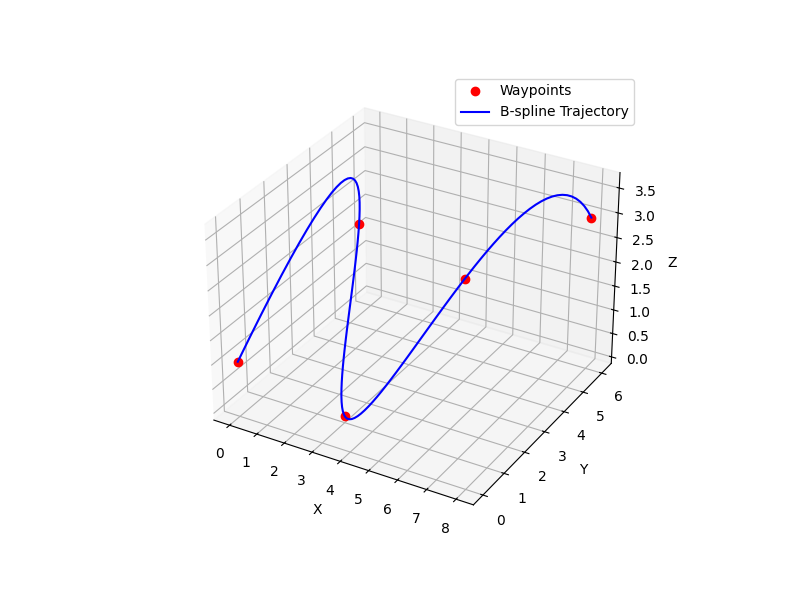

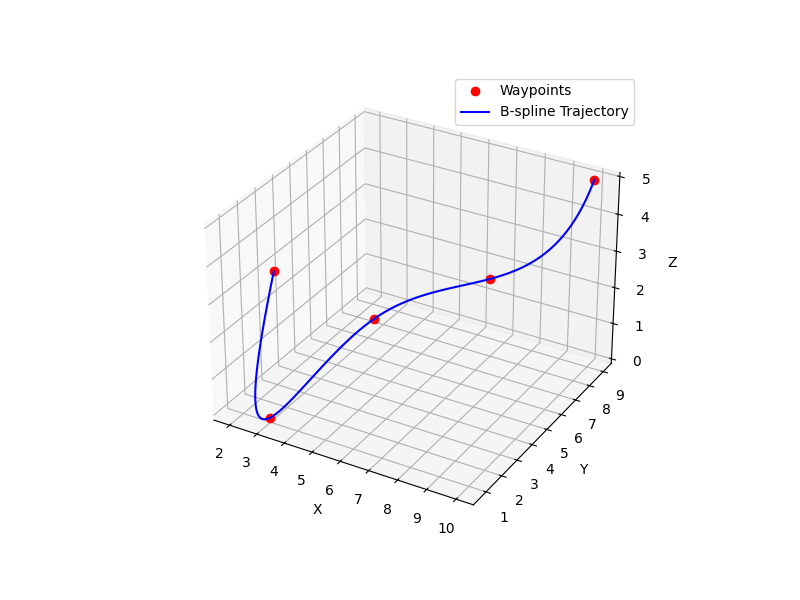

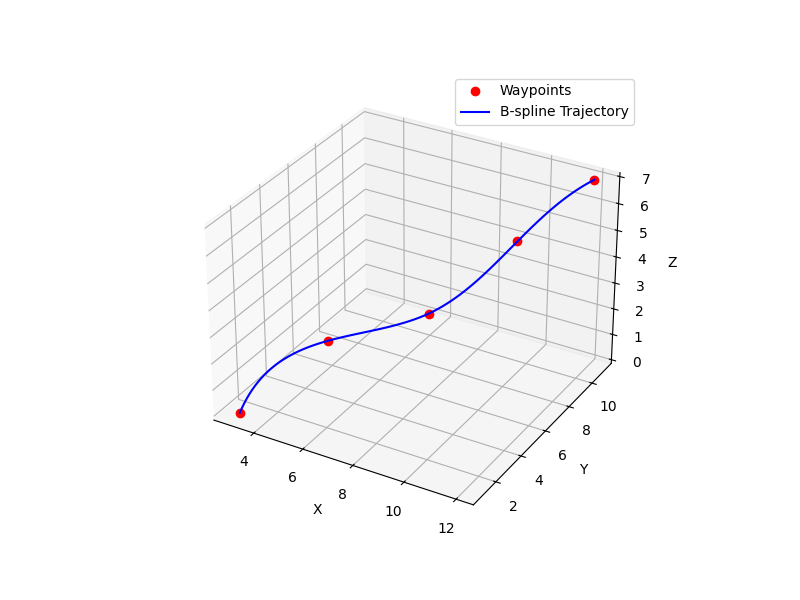

In [17]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Rolling buffer for waypoints
max_waypoints = 5  # Maintain last N points
waypoint_buffer = deque(maxlen=max_waypoints)

# Initialize with some waypoints (x, y, z)
initial_waypoints = [(0, 0, 1), (2, 3, 3), (3, 1, 0), (5, 4, 2)]
for wp in initial_waypoints:
    waypoint_buffer.append(wp)


def compute_arc_length(points):
    """Compute cumulative arc length for given waypoints."""
    points = np.array(points)
    diffs = np.diff(points, axis=0)
    segment_lengths = np.linalg.norm(diffs, axis=1)  # Euclidean distance
    arc_length = np.insert(np.cumsum(segment_lengths), 0, 0)  # Cumulative sum
    return arc_length


def update_spline(new_waypoint):
    """Update B-spline when a new waypoint arrives using arc-length parameterization."""
    waypoint_buffer.append(new_waypoint)

    if len(waypoint_buffer) < 4:  # Need at least 4 points for cubic spline
        return

    # Convert buffer to NumPy array
    waypoints = np.array(waypoint_buffer)

    # Compute cumulative arc length
    s = compute_arc_length(waypoints)

    # Create finer arc-length parameter grid
    s_fine = np.linspace(s[0], s[-1], 100)

    # Create B-spline for each coordinate
    spline_x = make_interp_spline(s, waypoints[:, 0], k=3)
    spline_y = make_interp_spline(s, waypoints[:, 1], k=3)
    spline_z = make_interp_spline(s, waypoints[:, 2], k=3)

    # Evaluate splines
    x_smooth = spline_x(s_fine)
    y_smooth = spline_y(s_fine)
    z_smooth = spline_z(s_fine)

    # Plot updated trajectory
    plt.clf()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(waypoints[:, 0], waypoints[:, 1], waypoints[:, 2], 'ro', label='Waypoints')
    ax.plot(x_smooth, y_smooth, z_smooth, 'b-', label='B-spline Trajectory')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.draw()
    plt.pause(0.1)


# Simulate incoming waypoints dynamically
for new_wp in [(8, 6, 3), (10, 9, 5), (12, 11, 7)]:
    update_spline(new_wp)


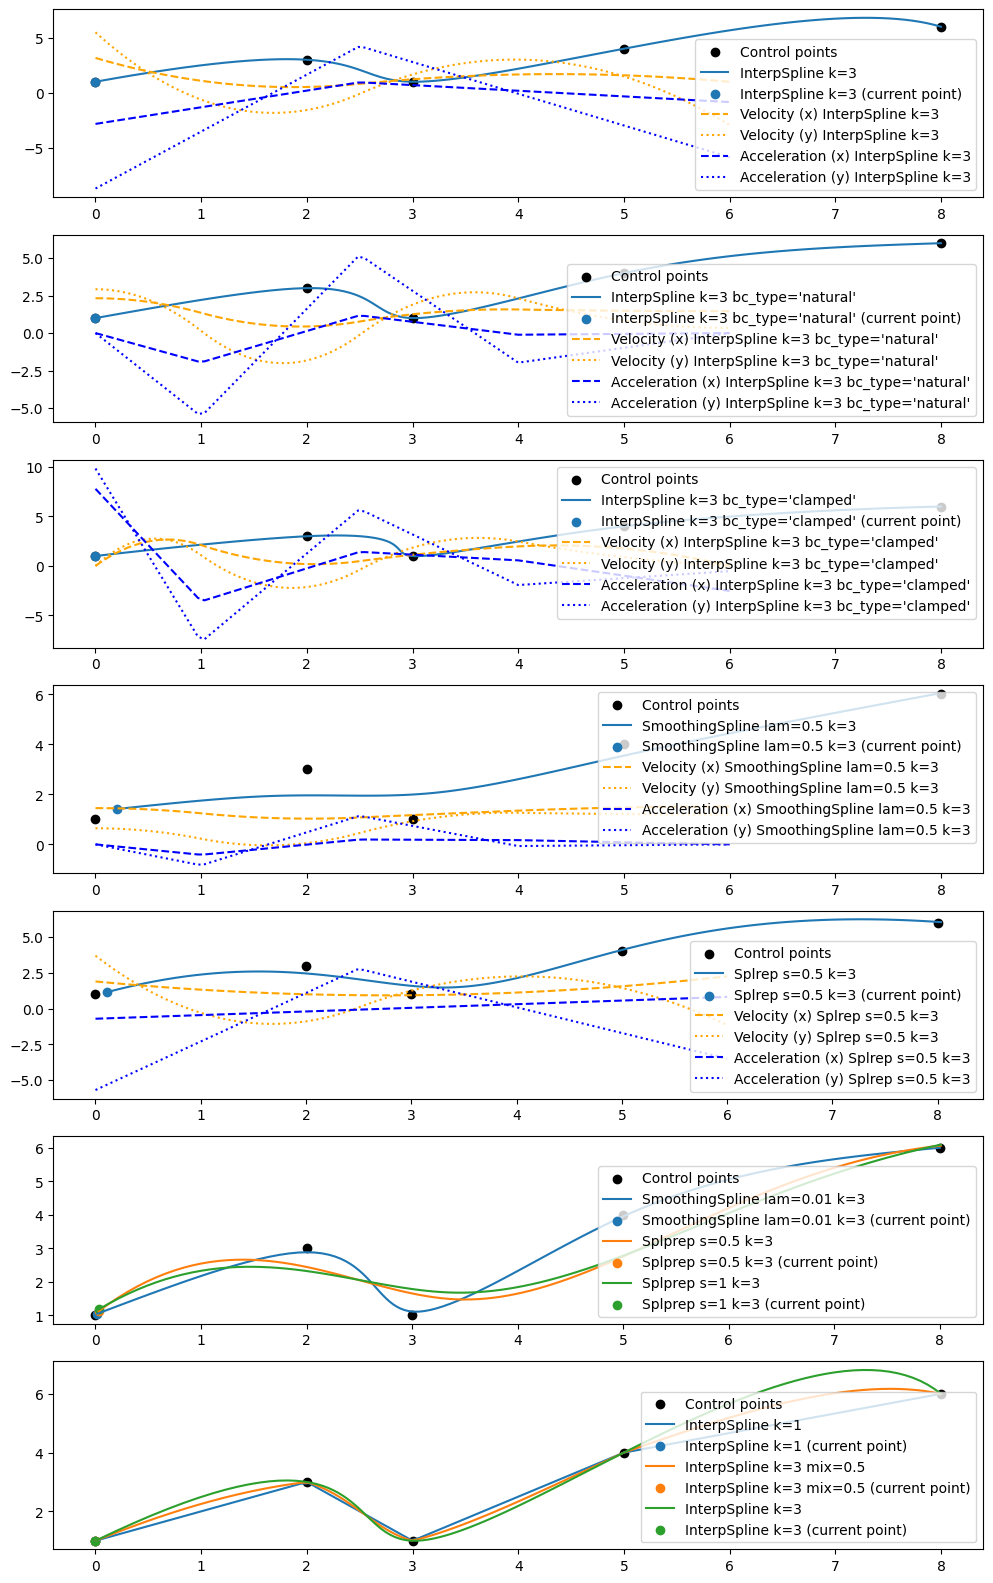

In [18]:
from smoothing_splines import plot_spline, SplineType

t = np.array([0, 1, 2.5, 4, 6])  # Time values (not uniformly spaced)
x = np.array([0, 2, 3, 5, 8])  # X trajectory
y = np.array([1, 3, 1, 4, 6])  # Y trajectory

control_points = np.array([x, y, t]).T

fig, axes = plt.subplots(7, 1, figsize=(12, 20))
plot_i = 0

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 3, derivatives=2)
ax.legend()

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 3, derivatives=2, bc_type='natural')
ax.legend()

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 3, derivatives=2, bc_type='clamped')
ax.legend()


ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 0.5, derivatives=2, spline_type=SplineType.smoothing)
ax.legend()

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 0.5, derivatives=2, spline_type=SplineType.splrep)
ax.legend()

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 0.01, spline_type=SplineType.smoothing)
plot_spline(ax, 0, control_points, 0.5, spline_type=SplineType.splprep)
plot_spline(ax, 0, control_points, 1, spline_type=SplineType.splprep)
ax.legend()

ax = axes[plot_i]
plot_i += 1
ax.scatter(x, y, c='k', label='Control points')
plot_spline(ax, 0, control_points, 1, mix=1)
plot_spline(ax, 0, control_points, 3, mix=0.5)
plot_spline(ax, 0, control_points, 3, mix=1)
ax.legend()

fig


# An abandoned attempt to use smoothing splines for gait generation

## Summary and steps forward (pun intended)

With the current approach we have achieved decent results and it helped us to get a basic understanding of gaits generation, however it has a serious limitations:
 1. It is not possible to transition between gaits as they are implemented as separate classes
 2. There is no transition in and out of the gait from standing position.
 3. Different gaits have different trajectories, however the only thing that has to change is the order in which legs are lifted.
 4. Phase logic is mixed with trajectory logic.

Lets rework the code to address all these issues and have production ready solution we will use in the next notebook that will be taking all we have learned so far to real ROS implementation controlling a simulated robot in Gazebo.

Our new approach should satisfy the following requirements:
 1. Allow defining a gait trajectory.
 2. Allow defining a gait sequence.
 3. Allow defining a gait generator function that will combine the two above given a set of parameters.
 4. Allow steering, turing and transitioning between gaits and positions.

1 and 2 are fairly straightforward and we have seen some solution using trigonometrical functions and polynomials already, however they do not allow proper mixing of the trajectories needed to achieve smooth transitions. 3 and 4 require a function that allows mixing. That is a task for a [smoothing spline function](https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html), e.g. a [B-spline](https://en.wikipedia.org/wiki/B-spline). It allows a smooth transition between control points while remaining stable if some of the control points are changed.

### Gait trajectory function

A good trajectory function has a smooth lift stage and flat stance stage. A simple rectified sinusoidal function did the trick in the previous example of tripod gait:

\begin{equation}
Z_o=\max(0, \sin(t))
\end{equation}

(see plot below)

The next step is to define control points for the B-spline that will give a similar trajectory.

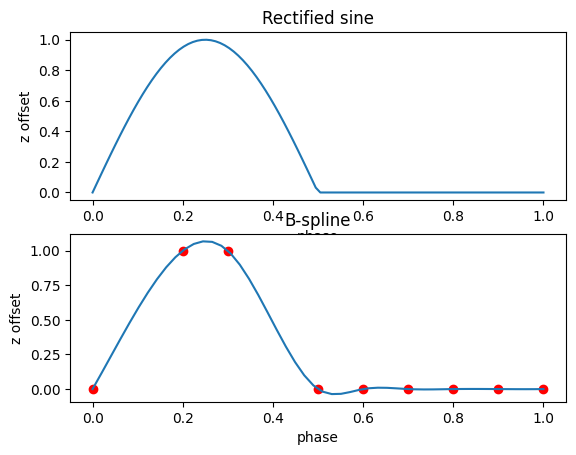

In [20]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


def rectified_sin_trajectory(phase):
    t = phase * 2 * np.pi
    return np.maximum(0, np.sin(t))


phase = np.linspace(0, 1, 100)

rectified_sin_z = rectified_sin_trajectory(phase)
##############################
fig, axes = plt.subplots(2, 1)

ax = axes[0]
ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('Rectified sine')

ax.plot(phase, rectified_sin_z)
##############################

num_items = 9
spline_x = np.array([0, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])[0:num_items]
spline_z = np.array([0, 1, 1, 0, 0, 0, 0, 0, 0])[0:num_items]
bspline_trajectory = make_interp_spline(spline_x, spline_z, k=3)

##############################
ax = axes[1]
ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('B-spline')

phase_new = np.linspace(0, spline_x[-1], 50)
ax.plot(phase_new, bspline_trajectory(phase_new))
ax.scatter(spline_x, spline_z, c='r')

display(fig)

For the sake of completeness, this is how bezier curve will look like. As you can see, it doesn't follow control points, and thus is not the best choice for our use case.

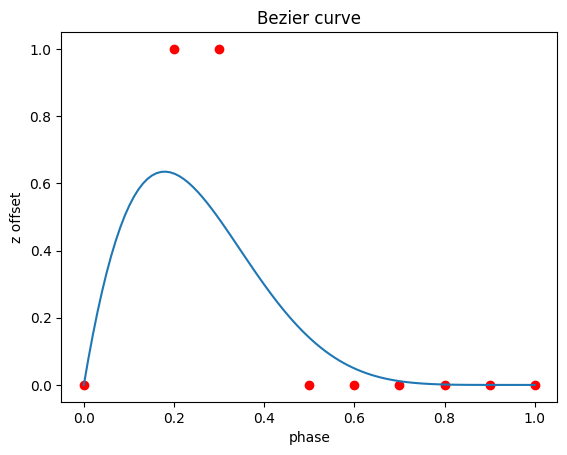

In [21]:
fig, ax = plt.subplots(1, 1)

ax.set_xlabel('phase')
ax.set_ylabel('z offset')
ax.set_title('Bezier curve')

xnew = np.linspace(0, 1, 10)
points = np.array([spline_x, spline_z]).T
ax.plot(phase, [bezier_curve(points, t)[1] for t in phase])
ax.scatter(points[:, 0], points[:, 1], c='r')

display(fig)

### Defining gaits as b-spline control points

Having BSplines as interpolation mechanism it is easy to define gaits as a sequence of control points.

As we already know every gait has two phases: swing and stance. The first parameter for those phases is the duration.

Each phase has its own additional parameters:
 1. swing phase:
    - lift height
    - step length
    - swing speed
 2. stance phase:
    - step length
    - stance speed

To keep things simple for the first iteration we are going to keep speed constant and equal between phases.

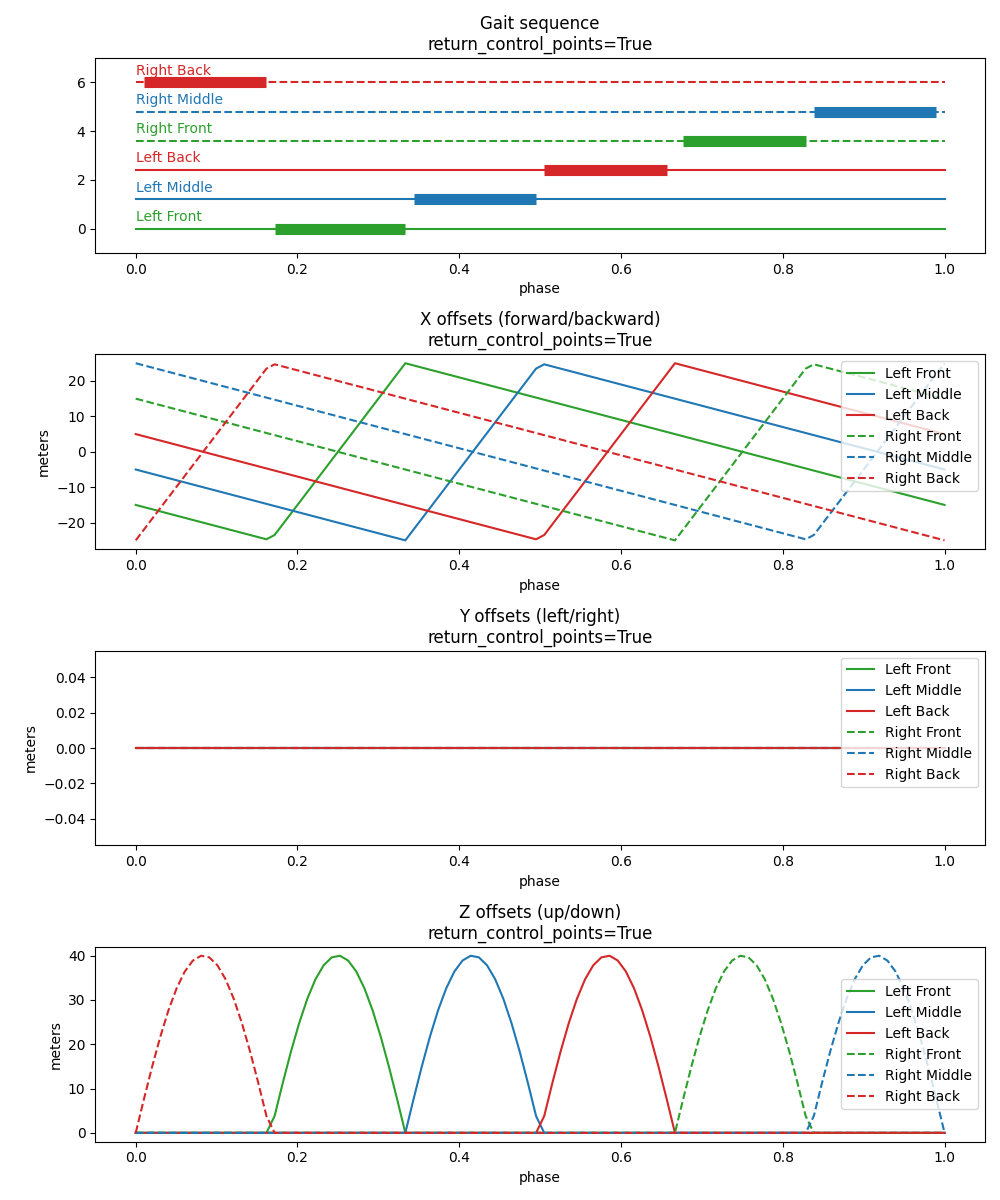

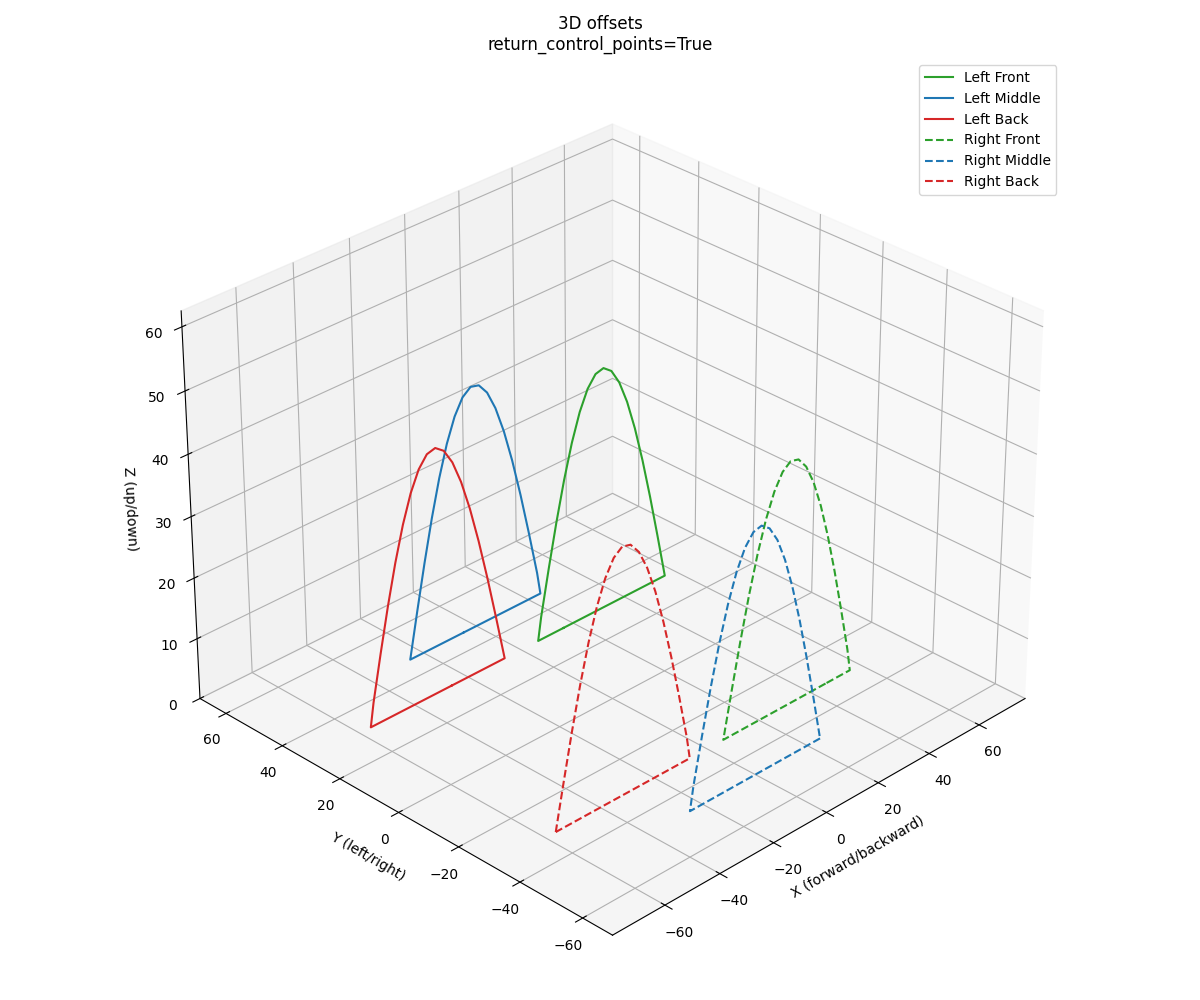

In [23]:
from abc import abstractmethod
import enum

from gait_generators import GaitGenerator
from models import HexapodLeg
from point import Point3D
from scipy.interpolate import make_interp_spline


class Gait(enum.Enum):
    ripple = enum.auto()
    wave = enum.auto()
    tripod = enum.auto()


class GaitParameters:
    def __init__(self, step_length=50, step_height=40):
        self.step_length = step_length
        self.step_height = step_height

    @property
    @abstractmethod
    def lift_duration(self):
        pass

    @property
    def phase_offset_for_leg(self, leg):
        pass


class ParametricGaitGenerator(GaitGenerator):
    def __init__(
        self,
        gait=Gait.wave,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
    ):
        """
        Initialize the ParametricGaitGenerator.

        Parameters:
        -----------
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height

        self.full_phase = 1.0
        self.__gait = gait

        # Leg phase is split into lift and push phases.
        # 0..lift_duration - lift phase
        # lift_duration..1.0 - push phase
        if self.__gait == Gait.wave:
            __leg_sequence = [
                HexapodLeg.right_back,
                HexapodLeg.right_middle,
                HexapodLeg.right_front,
                HexapodLeg.left_back,
                HexapodLeg.left_middle,
                HexapodLeg.left_front,
            ]

            leg_count = len(__leg_sequence)
            self.lift_duration = self.full_phase / leg_count

            self.leg_phase_offset = {
                leg: self.lift_duration * i for i, leg in enumerate(__leg_sequence)
            }

            self.last_offset = {leg: np.array([0, 0, 0]) for leg in __leg_sequence}
            self.last_phase = {leg: 0 for leg in __leg_sequence}
        else:
            raise NotImplementedError()

        super().__init__()

    def get_offsets_at_phase(
        self, phase, gait=Gait.wave, return_control_points=False
    ) -> dict[str, Point3D]:
        return {
            leg: self.get_offsets_at_phase_for_leg(leg, phase, gait, return_control_points)
            for leg in self.leg_phase_offset
        }

    def get_offsets_at_phase_for_leg(
        self, leg, phase, gait=Gait.wave, return_control_points=True
    ) -> Point3D:
        leg_phase = self.leg_phase_offset[leg] + phase
        # leg_phase = phase # ignore leg offset for now, all legs lift at the same time
        leg_phase %= self.full_phase

        next_control_point = self.get_control_points_at_phase(leg_phase)
        if return_control_points:
            return Point3D(next_control_point)

        # last_phase = self.last_phase[leg]
        # since_last_phase = leg_phase - self.last_phase[leg]
        self.last_phase[leg] = leg_phase

        # spline_phase_step = 0.1
        spline = np.array(
            [
                self.last_offset[leg],
                next_control_point,
                # self.get_control_points_at_phase(leg_phase + spline_phase_step),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 2),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 3),
                # self.get_control_points_at_phase(leg_phase + spline_phase_step * 4),
            ]
        )
        if leg_phase < self.lift_duration:
            # Swing phase - leg in air moving forward
            spline_phase = np.interp(leg_phase, [0, self.lift_duration], [0, 1])
        else:
            # Stance phase - leg on ground moving backward
            spline_phase = np.interp(leg_phase, [self.lift_duration, 1], [0, 1])

        result = bezier_curve(spline, spline_phase)
        result[0] = next_control_point[0]

        # spline_x, spline_y, spline_z = self.__bspline(spline)
        # spline_phase = np.interp(leg_phase, [last_phase, last_phase + since_last_phase + spline_phase_step * 4], [0, 1])
        # result = [spline_x(spline_phase), spline_y(spline_phase), spline_z(spline_phase)]
        self.last_offset[leg] = result

        return Point3D(result)

    def get_control_points_at_phase(self, leg_phase) -> np.ndarray:
        half_step = self.step_length / 2
        if leg_phase < self.lift_duration:
            # Swing phase - leg in air moving forward
            t = np.interp(leg_phase, [0, self.lift_duration], [0, 1])
            x_control_point = np.interp(leg_phase, [0, self.lift_duration], [-half_step, half_step])
            z_control_point = np.sin(t * np.pi) * self.step_height
        else:
            # Stance phase - leg on ground moving backward
            x_control_point = np.interp(leg_phase, [self.lift_duration, 1], [half_step, -half_step])
            z_control_point = 0  # On ground

        return np.array(
            [
                x_control_point,
                0,
                z_control_point,
            ]
        )

    @staticmethod
    def __bspline(control_points: np.ndarray):
        """
        Compute a smooth B-spline interpolation of control points using make_interp_spline.

        :param control_points: List of control points [[x0, y0], [x1, y1], ...]
        :return: Interpolated curve points
        """
        t = np.linspace(0, 1, len(control_points))

        control_x, control_y, control_z = zip(*control_points)
        spline_x = make_interp_spline(t, control_x)
        spline_y = make_interp_spline(t, control_y)
        spline_z = make_interp_spline(t, control_z)

        return spline_x, spline_y, spline_z


gait_gen = ParametricGaitGenerator()
gait_gen.visualize_continuous(_steps=100, return_control_points=True)
_ = gait_gen.visualize_continuous_in_3d(_steps=100, return_control_points=True)

# gait_gen.visualize_continuous(_steps=100, return_control_points=False)
# _ = gait_gen.visualize_continuous_in_3d(_steps=100, return_control_points=False)

In [ ]:
# hexapod = HexapodModel()
# hexapod.forward_kinematics(0, -25, 110)

# directional_param_gait_gen = DirectionalGaitGenerator(gait_gen)
# anim = animate_hexapod_gait_with_direction(
#     hexapod,
#     directional_param_gait_gen,
#     interactive=False,
#     skip=True,  ######
#     animate_trajectory=True,
#     animate_direction_degrees=False,
#     repeat=1,
# )
# inter = animate_hexapod_gait_with_direction(
#     hexapod, directional_param_gait_gen, interactive=True, skip=False
# )